In [1]:
import torch
from depth_estimation.depth_anything.dpt import DepthAnything
from pathlib import Path
import os
from depth_estimation.estimation_model import DepthModel
import psutil
import threading
import time
from datetime import datetime
import pandas as pd
import numpy as np
import GPUtil
import gc  # Garbage collector
import matplotlib.pyplot as plt

import statistics
from typing import Callable, Any, List, Tuple, Dict
from concurrent.futures import ThreadPoolExecutor
from dataclasses import dataclass


%load_ext autoreload
%autoreload 2

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using the device: {device}")

xFormers not available
xFormers not available


Using the device: cuda


In [2]:
# Adjust the root path as necessary
root_path = Path(os.getcwd()).parents[0]
weights_path_dict = {
    'v1': {
        "vits": root_path / "tmp/model-weights/depth_anything_v1_vits.pth",
        "vitb": root_path / "tmp/model-weights/depth_anything_v1_vitb.pth",
        "vitl": root_path / "tmp/model-weights/depth_anything_v1_vitl.pth",
    },
    'v2': {
        "vits": root_path / "tmp/model-weights/depth_anything_v2_vits.pth",
        "vitb": root_path / "tmp/model-weights/depth_anything_v2_vitb.pth",
        "vitl": root_path / "tmp/model-weights/depth_anything_v2_vitl.pth",
    },
}

model_configs = {
    "vits": {"encoder": "vits", "features": 64, "out_channels": (48, 96, 192, 384)},
    "vitb": {"encoder": "vitb", "features": 128, "out_channels": (96, 192, 384, 768)},
    "vitl": {
        "encoder": "vitl",
        "features": 256,
        "out_channels": (256, 512, 1024, 1024),
    },
    "vitg": {
        "encoder": "vitg",
        "features": 384,
        "out_channels": (1536, 1536, 1536, 1536),
    },
}

In [3]:
def load_depth_anything(path, configs, device):

    model = DepthAnything(**configs)
    model.load_state_dict(torch.load(path, 
                                     map_location='cpu',
                                     weights_only=True))
    model = model.to(device)
    model.eval()
    return model

### Create benchmark

In [4]:
import time
import threading
import psutil
import GPUtil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from typing import Callable, Tuple, Any, Dict, List, Optional
from dataclasses import dataclass
from PIL import Image
import statistics

class ResourceTracker:
    def __init__(self, tracking_interval: float = 1.0, output_dir: str = "benchmark_results"):
        """
        Initialize the resource tracker.

        Args:
            tracking_interval: Time between measurements in seconds
            output_dir: Directory to save results
        """
        self.tracking_interval = tracking_interval
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)

        self.cpu_percentages: List[float] = []
        self.ram_percentages: List[float] = []
        self.gpu_percentages: List[float] = []
        self.gpu_memory_percentages: List[float] = []
        self.timestamps: List[float] = []

        self.start_time: Optional[float] = None
        self.is_tracking = False
        self.tracking_thread: Optional[threading.Thread] = None

    def _get_gpu_stats(self) -> Tuple[float, float]:
        """Get GPU utilization and memory usage."""
        try:
            gpus = GPUtil.getGPUs()
            if gpus:
                gpu = gpus[0]  # Get primary GPU
                return gpu.load * 100, (gpu.memoryUsed / gpu.memoryTotal) * 100
            return 0.0, 0.0
        except Exception:
            return 0.0, 0.0

    def _track_resources(self):
        """Track system resources at regular intervals."""
        while self.is_tracking:
            current_time = time.time() - self.start_time

            # CPU utilization (across all cores)
            cpu_percent = psutil.cpu_percent(interval=None)

            # RAM utilization
            ram_percent = psutil.virtual_memory().percent

            # GPU utilization and memory
            gpu_util, gpu_mem = self._get_gpu_stats()

            # Store measurements
            self.timestamps.append(current_time)
            self.cpu_percentages.append(cpu_percent)
            self.ram_percentages.append(ram_percent)
            self.gpu_percentages.append(gpu_util)
            self.gpu_memory_percentages.append(gpu_mem)

            time.sleep(self.tracking_interval)

    def start_tracking(self):
        """Start tracking system resources."""
        self.is_tracking = True
        self.start_time = time.time()
        self.tracking_thread = threading.Thread(target=self._track_resources)
        self.tracking_thread.start()

    def stop_tracking(self):
        """Stop tracking system resources."""
        self.is_tracking = False
        if self.tracking_thread:
            self.tracking_thread.join()

    def get_summary_stats(self) -> Dict[str, Dict[str, float]]:
        """Calculate summary statistics for all tracked resources."""
        metrics = {
            'CPU Utilization': self.cpu_percentages,
            'RAM Utilization': self.ram_percentages,
            'GPU Utilization': self.gpu_percentages,
            'GPU Memory Utilization': self.gpu_memory_percentages
        }

        summary = {}
        for name, values in metrics.items():
            if values:
                summary[name] = {
                    'mean': np.mean(values),
                    'min': np.min(values),
                    'max': np.max(values),
                    'std': np.std(values),
                    'p95': np.percentile(values, 95),
                    'p99': np.percentile(values, 99)
                }
            else:
                summary[name] = {
                    'mean': 0, 'min': 0, 'max': 0,
                    'std': 0, 'p95': 0, 'p99': 0
                }

        return summary

    def save_results(self, test_name: str = "benchmark"):
        """Save tracking results to CSV and generate plots."""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Create DataFrame
        df = pd.DataFrame({
            'timestamp': self.timestamps,
            'cpu_utilization': self.cpu_percentages,
            'ram_utilization': self.ram_percentages,
            'gpu_utilization': self.gpu_percentages,
            'gpu_memory_utilization': self.gpu_memory_percentages
        })

        # Save to CSV
        csv_path = self.output_dir / f"{test_name}_resources_{timestamp}.csv"
        df.to_csv(csv_path, index=False)

        # Create plots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'System Resource Utilization - {test_name}')

        # CPU Plot
        axs[0, 0].plot(self.timestamps, self.cpu_percentages)
        axs[0, 0].set_title('CPU Utilization')
        axs[0, 0].set_xlabel('Time (s)')
        axs[0, 0].set_ylabel('Utilization (%)')
        axs[0, 0].set_ylim(0, 100)

        # RAM Plot
        axs[0, 1].plot(self.timestamps, self.ram_percentages)
        axs[0, 1].set_title('RAM Utilization')
        axs[0, 1].set_xlabel('Time (s)')
        axs[0, 1].set_ylabel('Utilization (%)')
        axs[0, 1].set_ylim(0, 100)

        # GPU Plot
        axs[1, 0].plot(self.timestamps, self.gpu_percentages)
        axs[1, 0].set_title('GPU Utilization')
        axs[1, 0].set_xlabel('Time (s)')
        axs[1, 0].set_ylabel('Utilization (%)')
        axs[1, 0].set_ylim(0, 100)

        # GPU Memory Plot
        axs[1, 1].plot(self.timestamps, self.gpu_memory_percentages)
        axs[1, 1].set_title('GPU Memory Utilization')
        axs[1, 1].set_xlabel('Time (s)')
        axs[1, 1].set_ylabel('Utilization (%)')
        axs[1, 1].set_ylim(0, 100)

        plt.tight_layout()
        plot_path = self.output_dir / f"{test_name}_resources_{timestamp}.png"
        plt.savefig(plot_path)
        plt.close()

        return csv_path, plot_path

@dataclass
class BenchmarkResults:
    """Class to store benchmark results"""
    mean_latency: float
    p90_latency: float
    p95_latency: float
    p99_latency: float
    throughput: float
    individual_latencies: List[float]
    total_inferences: int
    total_time: float

def measure_single_inference(func: Callable, image: Any, model: Any) -> float:
    """Measure the latency of a single inference."""
    start_time = time.perf_counter()
    _ = func(image, model)
    end_time = time.perf_counter()
    return end_time - start_time

def benchmark_model(
    inference_func: Callable,
    images: List[Any],
    model: Any,
    num_runs: int = 100,
    num_warmup_runs: int = 10,
    batch_duration: int = 60  # Duration in seconds for throughput test
) -> BenchmarkResults:
    """
    Comprehensive benchmark of the model, measuring both latency and throughput.
    """
    num_images = len(images)
    image_index = 0

    # Warmup runs
    print("Performing warmup runs...")
    for i in range(num_warmup_runs):
        image = images[image_index]
        image_index = (image_index + 1) % num_images
        _ = inference_func(image, model)
        print(f"Warmup run {i+1}/{num_warmup_runs} completed")

    # Measure latency
    print(f"\nMeasuring latency over {num_runs} runs...")
    latencies = []
    for i in range(num_runs):
        image = images[image_index]
        image_index = (image_index + 1) % num_images
        latency = measure_single_inference(inference_func, image, model)
        latencies.append(latency)
        if (i + 1) % 10 == 0:
            print(f"Completed {i + 1}/{num_runs} runs")

    # Calculate latency statistics
    mean_latency = statistics.mean(latencies)
    p90_latency = np.percentile(latencies, 90)
    p95_latency = np.percentile(latencies, 95)
    p99_latency = np.percentile(latencies, 99)

    # Measure throughput
    print(f"\nMeasuring throughput over {batch_duration} seconds...")
    start_time = time.perf_counter()
    inference_count = 0

    while (time.perf_counter() - start_time) < batch_duration:
        try:
            image = images[image_index]
            image_index = (image_index + 1) % num_images
            _ = inference_func(image, model)
            inference_count += 1

            # Log progress
            if inference_count % 10 == 0:
                elapsed = time.perf_counter() - start_time
                current_throughput = inference_count / elapsed
                print(f"Progress: {inference_count} inferences completed. "
                      f"Current throughput: {current_throughput:.2f} inferences/second")
        except Exception as e:
            print(f"Error in inference: {e}")
            continue

    total_time = time.perf_counter() - start_time
    throughput = inference_count / total_time if total_time > 0 else 0

    print(f"\nThroughput test completed:")
    print(f"Total inferences: {inference_count}")
    print(f"Total time: {total_time:.2f} seconds")
    print(f"Final throughput: {throughput:.2f} inferences/second")

    return BenchmarkResults(
        mean_latency=mean_latency,
        p90_latency=p90_latency,
        p95_latency=p95_latency,
        p99_latency=p99_latency,
        throughput=throughput,
        individual_latencies=latencies,
        total_inferences=inference_count,
        total_time=total_time
    )

def benchmark_model_with_resources(
    inference_func: Callable,
    images: List[Any],
    model: Any,
    num_runs: int = 100,
    num_warmup_runs: int = 10,
    batch_duration: int = 60,
    test_name: str = "model_benchmark"
) -> Tuple[BenchmarkResults, Dict[str, Dict[str, float]]]:
    """
    Run benchmark with resource tracking.
    """
    # Initialize resource tracker
    tracker = ResourceTracker(tracking_interval=1.0)

    print(f"\nStarting benchmark: {test_name}")
    print("Initializing resource tracking...")

    # Start resource tracking
    tracker.start_tracking()

    try:
        # Run benchmark
        benchmark_results = benchmark_model(
            inference_func=inference_func,
            images=images,
            model=model,
            num_runs=num_runs,
            num_warmup_runs=num_warmup_runs,
            batch_duration=batch_duration
        )
    finally:
        # Ensure tracker is stopped
        tracker.stop_tracking()

    # Get resource usage summary
    resource_summary = tracker.get_summary_stats()

    # Save results
    csv_path, plot_path = tracker.save_results(test_name)
    print(f"\nResults saved to:")
    print(f"CSV: {csv_path}")
    print(f"Plot: {plot_path}")

    return benchmark_results, resource_summary

def print_benchmark_results(results: BenchmarkResults):
    """Pretty print benchmark results."""
    print("\n=== Benchmark Results ===")
    print(f"Mean Latency: {results.mean_latency*1000:.2f} ms")
    print(f"90th Percentile Latency: {results.p90_latency*1000:.2f} ms")
    print(f"95th Percentile Latency: {results.p95_latency*1000:.2f} ms")
    print(f"99th Percentile Latency: {results.p99_latency*1000:.2f} ms")
    print(f"Throughput: {results.throughput:.2f} inferences/second")
    print(f"Total Inferences: {results.total_inferences}")
    print(f"Total Time: {results.total_time:.2f} seconds")

def print_resource_summary(summary: Dict[str, Dict[str, float]]):
    """Pretty print resource utilization summary."""
    print("\n=== Resource Utilization Summary ===")
    for metric, stats in summary.items():
        print(f"\n{metric}:")
        print(f"  Mean: {stats['mean']:.2f}%")
        print(f"  Min:  {stats['min']:.2f}%")
        print(f"  Max:  {stats['max']:.2f}%")
        print(f"  Std:  {stats['std']:.2f}%")
        print(f"  P95:  {stats['p95']:.2f}%")
        print(f"  P99:  {stats['p99']:.2f}%")

# Standard benchmark configurations
STANDARD_BENCHMARK_CONFIG = {
    "num_runs": 100,
    "num_warmup_runs": 10,
    "batch_duration": 300,  # 5 minutes
    "description": "Standard benchmark configuration for performance testing"
}

def run_comprehensive_benchmark(model, images, config, inference_wrapper):
    """
    Run comprehensive benchmarking.
    """
    results = {}
    resources = {}

    # Run latency test
    print(f"\nRunning latency benchmark with {config['num_runs']} iterations...")
    latency_results, resource_summary = benchmark_model_with_resources(
        inference_wrapper,
        images=images,
        model=model,
        num_runs=config['num_runs'],
        num_warmup_runs=config['num_warmup_runs'],
        batch_duration=60,  # Short duration for latency test
        test_name='model_benchmark_latency'
    )
    results['latency'] = latency_results
    resources['latency'] = resource_summary

    # Run throughput test
    print("\nRunning throughput benchmark...")
    throughput_results, resource_summary = benchmark_model_with_resources(
        inference_wrapper,
        images=images,
        model=model,
        num_runs=10,  # Number of runs not critical for throughput test
        num_warmup_runs=config['num_warmup_runs'],
        batch_duration=config['batch_duration'],
        test_name='model_benchmark_throughput'
    )
    results['throughput'] = throughput_results
    resources['throughput'] = resource_summary

    return results, resources

# Choose appropriate configuration based on your needs
config = STANDARD_BENCHMARK_CONFIG

print("Running benchmark with configuration:")
print(f"Description: {config['description']}")
print(f"Number of runs: {config['num_runs']}")
print(f"Warmup runs: {config['num_warmup_runs']}")
print(f"Batch duration: {config['batch_duration']} seconds")

Running benchmark with configuration:
Description: Standard benchmark configuration for performance testing
Number of runs: 100
Warmup runs: 10
Batch duration: 300 seconds


In [ ]:
# Example image path
# image_path = "/home/ap/3.png"
import cv2

def load_images(image_dir: str) -> List[np.ndarray]:
    """
    Load images from the specified directory.

    Args:
        image_dir: Path to the directory containing images.

    Returns:
        List[np.ndarray]: List of images as numpy arrays.
    """
    image_dir = Path(image_dir)
    if not image_dir.is_dir():
        raise TypeError("Invalid image path. Please provide a directory path.")

    images = []
    # Handle jpg and png images
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        for file in image_dir.glob(ext):
            img = cv2.imread(str(file))
            if img is not None:
                images.append(img)
    if not images:
        raise ValueError("No images found in the provided directory.")
    return images

def postprocess(model_output: np.ndarray) -> np.ndarray:
    """
    Postprocess the model output.

    Args:
        model_output: Raw output from the model.

    Returns:
        np.ndarray: Postprocessed output.
    """
    # Normalize the depth map to [0, 255] for visualization
    output = (model_output - model_output.min()) / (model_output.max() - model_output.min() + 1e-8)
    output *= 255
    output = output.astype(np.uint8)
    return output


# Create a wrapper function that matches the expected signature
def inference_wrapper(image: np.ndarray, model):
    """
    Perform full inference including preprocessing and postprocessing.

    Args:
        image (np.ndarray): Input image as a numpy array.
        model: Your model object.

    Returns:
        np.ndarray: Final output after postprocessing.
    """
    model_output = model.infer_image(image)
    final_output = postprocess(model_output)
    return final_output

images = load_images(str(Path(os.getcwd()).parents[2] / 'Data/1--Handshaking'))

# Run benchmarks for different model versions and encoders
for version in ['v1', 'v2']:
    for encoder in ['vits', 'vitb', 'vitl']:
        print(f"\nRunning benchmark for {version} - {encoder}")
        weights_path = weights_path_dict[version][encoder]
        model_config = model_configs[encoder]
        model = load_depth_anything(weights_path, model_config, device)

        results, resources = run_comprehensive_benchmark(model, images, config, inference_wrapper)

        print(f'\nResults of latency and throughput for {version} - {encoder}')
        # Print latency results
        print_benchmark_results(results['latency'])
        print_resource_summary(resources['latency'])

        # Print throughput results
        print_benchmark_results(results['throughput'])
        print_resource_summary(resources['throughput'])

        # ====================== Memory Cleanup ======================

        print("\nCleaning up resources to prevent memory leaks...")

        # Delete the model reference
        del model
        print("Deleted model reference.")

        # Clear CUDA cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            print("Cleared CUDA cache.")

        # Collect garbage
        gc.collect()
        print("Garbage collection completed.")

        # Optionally, print current GPU memory usage for verification
        if torch.cuda.is_available():
            gpu_memory = torch.cuda.memory_allocated(device) / (1024 ** 3)  # in GB
            gpu_memory_reserved = torch.cuda.memory_reserved(device) / (1024 ** 3)  # in GB
            print(f"Current GPU memory allocated: {gpu_memory:.2f} GB")
            print(f"Current GPU memory reserved: {gpu_memory_reserved:.2f} GB")
        print("Resource cleanup completed.\n")




Running benchmark for v1 - vits

Running latency benchmark with 100 iterations...

Starting benchmark: model_benchmark_latency
Initializing resource tracking...
Performing warmup runs...
Warmup run 1/10 completed
Warmup run 2/10 completed
Warmup run 3/10 completed
Warmup run 4/10 completed
Warmup run 5/10 completed
Warmup run 6/10 completed
Warmup run 7/10 completed
Warmup run 8/10 completed
Warmup run 9/10 completed
Warmup run 10/10 completed

Measuring latency over 100 runs...
Completed 10/100 runs
Completed 20/100 runs
Completed 30/100 runs
Completed 40/100 runs
Completed 50/100 runs
Completed 60/100 runs
Completed 70/100 runs
Completed 80/100 runs
Completed 90/100 runs
Completed 100/100 runs

Measuring throughput over 60 seconds...
Progress: 10 inferences completed. Current throughput: 18.91 inferences/second
Progress: 20 inferences completed. Current throughput: 18.28 inferences/second
Progress: 30 inferences completed. Current throughput: 17.56 inferences/second
Progress: 40 inf

DA-2K

In [8]:
!wget https://huggingface.co/datasets/depth-anything/DA-2K/resolve/main/DA-2K.zip
!unzip -q DA-2K.zip -d /home/artem-trybushenko/Projects/depth-estimation/tmp/

--2024-11-24 21:36:12--  https://huggingface.co/datasets/depth-anything/DA-2K/resolve/main/DA-2K.zip
Resolving huggingface.co (huggingface.co)... 65.9.95.61, 65.9.95.31, 65.9.95.114, ...
Connecting to huggingface.co (huggingface.co)|65.9.95.61|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/a8/2d/a82dcf14046fbd2d81edae5290092dfce4e3ffa99ae1ee90d0638cc64e477c65/ff0e48e7cc53273efd1312610e51f1ec87bea0b8a22daf37125fd81246592b81?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27DA-2K.zip%3B+filename%3D%22DA-2K.zip%22%3B&response-content-type=application%2Fzip&Expires=1732736172&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMjczNjE3Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2E4LzJkL2E4MmRjZjE0MDQ2ZmJkMmQ4MWVkYWU1MjkwMDkyZGZjZTRlM2ZmYTk5YWUxZWU5MGQwNjM4Y2M2NGU0NzdjNjUvZmYwZTQ4ZTdjYzUzMjczZWZkMTMxMjYxMGU1MWYxZWM4N2JlYTBiOGEyMmRhZjM3MTI1ZmQ4MTI0NjU5MmI4M

Calculating DA-2K accuracy of v1_vits model...


100%|██████████| 130/130 [02:32<00:00,  1.17s/it]


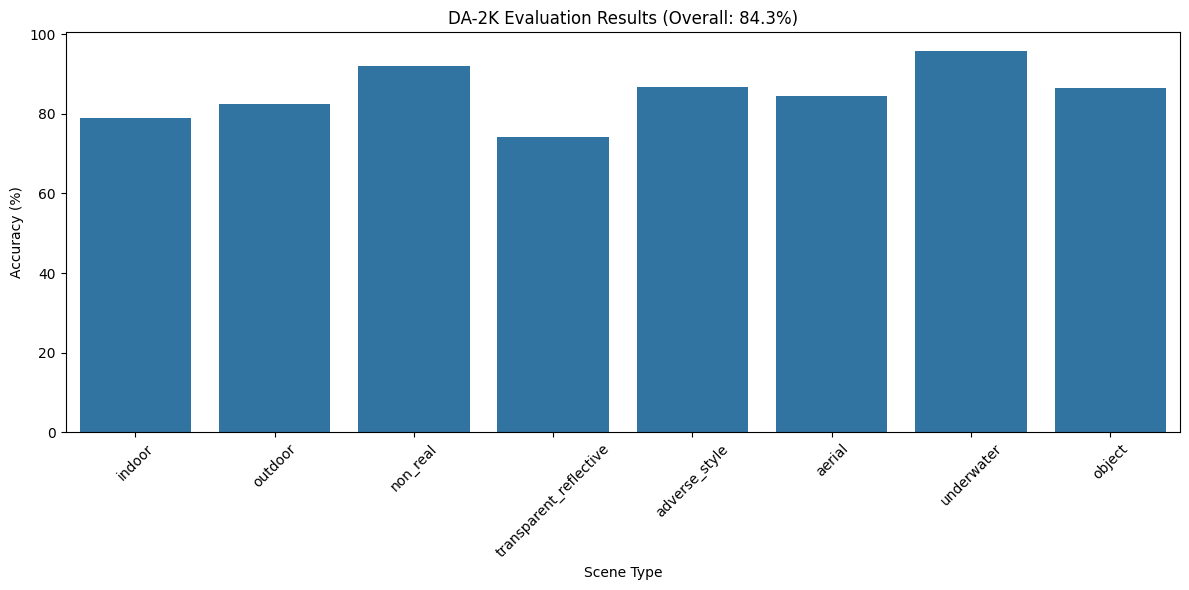

Deleted model reference.
Cleared CUDA cache.
Garbage collection completed.
Current GPU memory allocated: 0.24 GB
Current GPU memory reserved: 0.35 GB
Resource cleanup completed.

Calculating DA-2K accuracy of v1_vitb model...


100%|██████████| 259/259 [05:52<00:00,  1.36s/it]


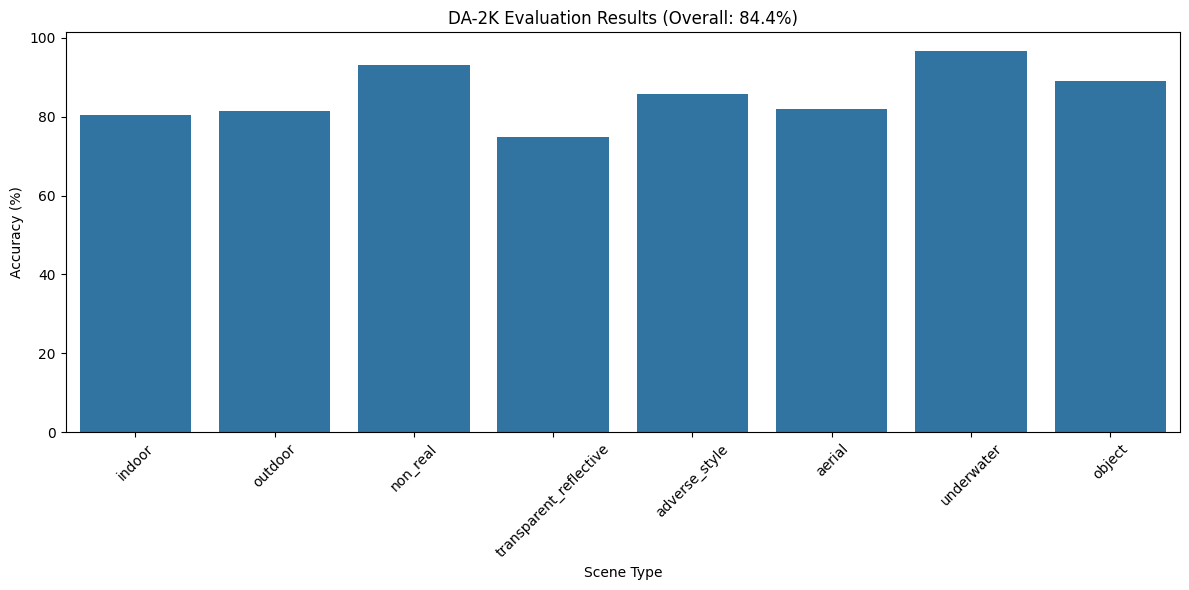

Deleted model reference.
Cleared CUDA cache.
Garbage collection completed.
Current GPU memory allocated: 0.24 GB
Current GPU memory reserved: 0.35 GB
Resource cleanup completed.

Calculating DA-2K accuracy of v1_vitl model...


100%|██████████| 517/517 [17:32<00:00,  2.04s/it]


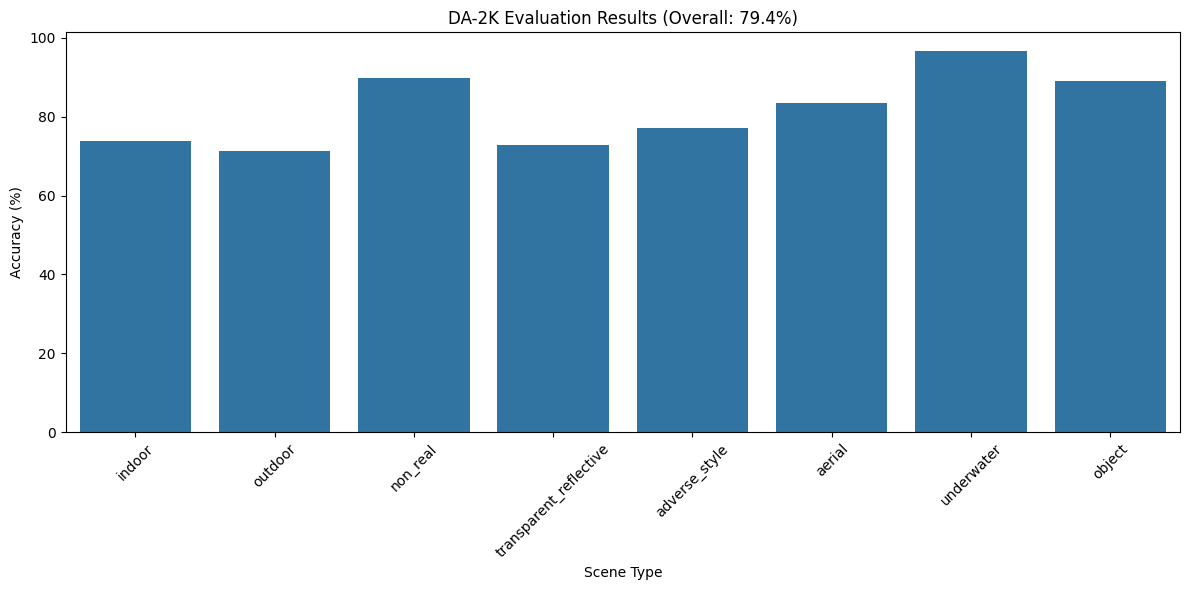

Deleted model reference.
Cleared CUDA cache.
Garbage collection completed.
Current GPU memory allocated: 0.24 GB
Current GPU memory reserved: 0.35 GB
Resource cleanup completed.

Calculating DA-2K accuracy of v2_vits model...


100%|██████████| 130/130 [02:32<00:00,  1.17s/it]


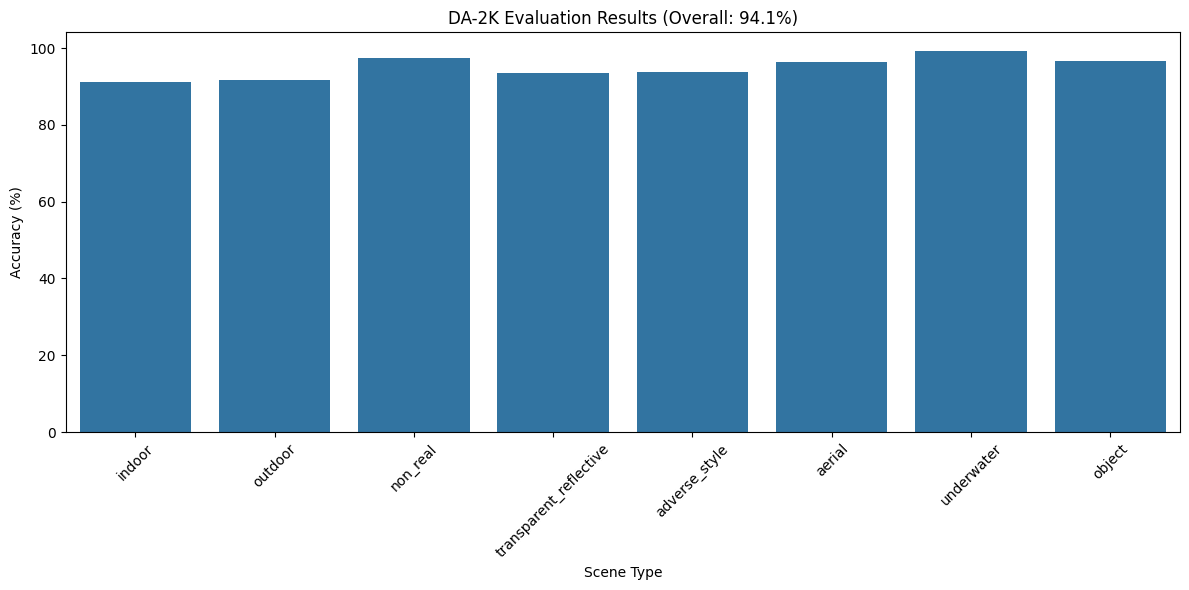

Deleted model reference.
Cleared CUDA cache.
Garbage collection completed.
Current GPU memory allocated: 0.24 GB
Current GPU memory reserved: 0.35 GB
Resource cleanup completed.

Calculating DA-2K accuracy of v2_vitb model...


100%|██████████| 259/259 [05:48<00:00,  1.35s/it]


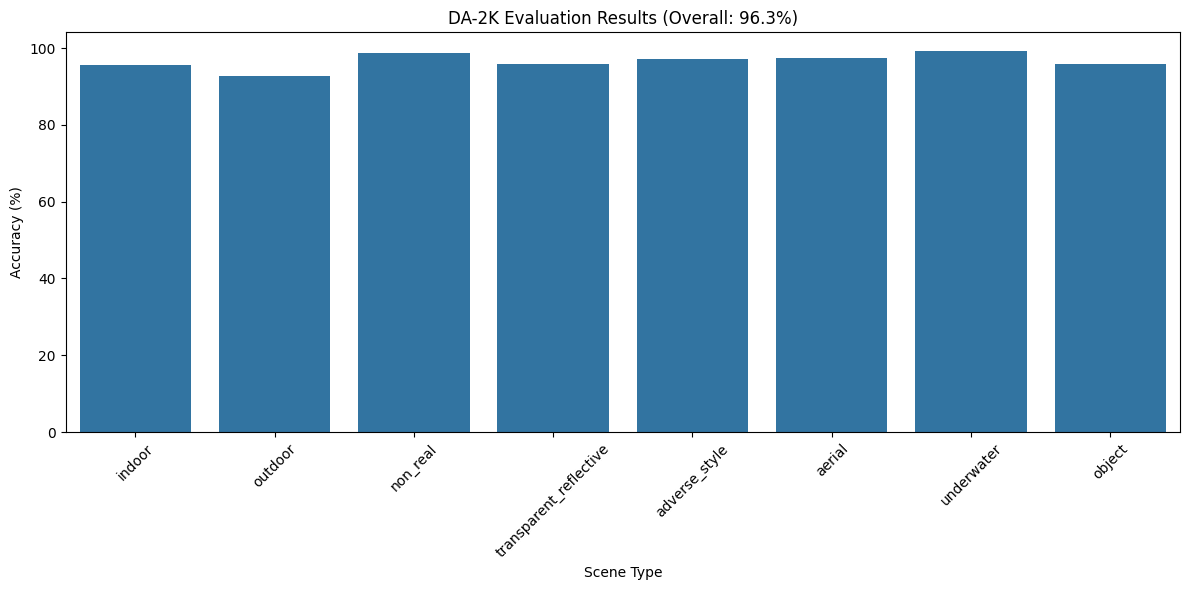

Deleted model reference.
Cleared CUDA cache.
Garbage collection completed.
Current GPU memory allocated: 0.24 GB
Current GPU memory reserved: 0.35 GB
Resource cleanup completed.

Calculating DA-2K accuracy of v2_vitl model...


100%|██████████| 517/517 [15:12<00:00,  1.77s/it]


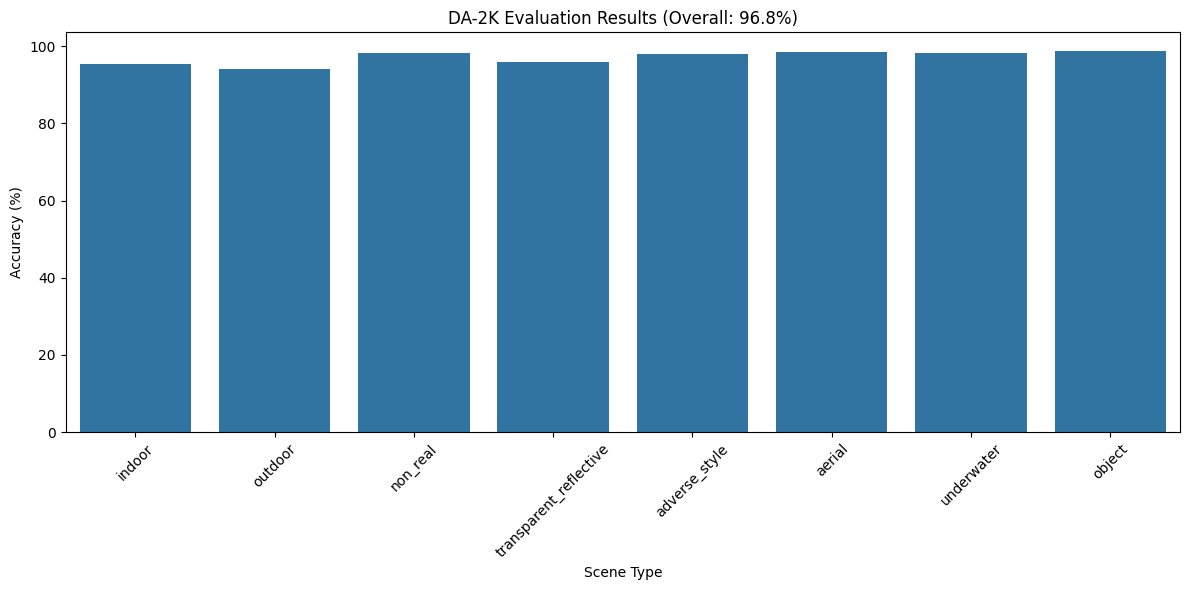

Deleted model reference.
Cleared CUDA cache.
Garbage collection completed.
Current GPU memory allocated: 0.24 GB
Current GPU memory reserved: 0.35 GB
Resource cleanup completed.


---Results of v1_vits model---

     Overall Accuracy: 84.28%
     Per-scene Accuracies:
          indoor: 79.05%
          outdoor: 82.56%
          non_real: 92.08%
          transparent_reflective: 74.30%
          adverse_style: 86.89%
          aerial: 84.54%
          underwater: 95.73%
          object: 86.49%

---Results of v1_vitb model---

     Overall Accuracy: 84.38%
     Per-scene Accuracies:
          indoor: 80.48%
          outdoor: 81.40%
          non_real: 93.07%
          transparent_reflective: 74.77%
          adverse_style: 85.67%
          aerial: 81.96%
          underwater: 96.58%
          object: 89.19%

---Results of v1_vitl model---

     Overall Accuracy: 79.45%
     Per-scene Accuracies:
          indoor: 73.81%
          outdoor: 71.22%
          non_real: 89.77%
          tra

In [ ]:
import json
from tqdm import tqdm
import seaborn as sns
from typing import Optional, Tuple, Dict, Union
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

class DA2KDataset(Dataset):
    """Dataset class for DA-2K benchmark"""
    def __init__(self, 
                 root_dir: str, 
                 scene_type: Optional[str] = None,
                 image_size: Tuple[int, int] = (384, 384)):  # Common input size for depth models
        self.root_dir = Path(root_dir)
        self.annotations_file = self.root_dir / 'annotations.json'
        self.image_size = image_size
        
        # Define standard preprocessing for depth estimation models
        self.transform = T.Compose([
            T.ToTensor(),  # Convert to tensor and scale to [0, 1]
            T.Resize(image_size, antialias=True),
            T.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                       std=[0.229, 0.224, 0.225])
        ])
        
        with open(self.annotations_file, 'r') as f:
            self.annotations = json.load(f)
            
        # Filter by scene type if specified
        if scene_type:
            self.annotations = {k: v for k, v in self.annotations.items() 
                              if scene_type in k}
        
        self.image_pairs = []
        for img_path, points in self.annotations.items():
            for point in points:
                self.image_pairs.append((img_path, point))

    def _scale_points(self, 
                     points: List[int], 
                     original_size: Tuple[int, int]) -> List[int]:
        """Scale points from original image size to model input size"""
        h_scale = self.image_size[0] / original_size[0]
        w_scale = self.image_size[1] / original_size[1]
        return [int(points[0] * h_scale), int(points[1] * w_scale)]

    def __len__(self) -> int:
        return len(self.image_pairs)

    def __getitem__(self, idx: int) -> Dict:
        img_path, point_data = self.image_pairs[idx]
        
        # Read image
        image = cv2.imread(str(self.root_dir / img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = image.shape[:2]  # (H, W)
        
        # Convert image to tensor and apply preprocessing
        image_tensor = self.transform(image)  # Shape: (3, H, W)
        
        # Scale points to match the resized image
        point1 = self._scale_points(point_data['point1'], original_size)
        point2 = self._scale_points(point_data['point2'], original_size)
        closer_point = 1 if point_data['closer_point'] == 'point1' else 2
        
        return {
            'image': image_tensor,  # Now a properly preprocessed torch.Tensor
            'point1': point1,
            'point2': point2,
            'closer_point': closer_point,
            'image_path': img_path,
            'original_size': original_size
        }

class DA2KEvaluator:
    """Evaluator class for DA-2K benchmark"""
    def __init__(self, model, device: str = 'cuda'):
        self.model = model
        self.device = device
        self.model = self.model.to(device)
        self.scene_types = ['indoor', 'outdoor', 'non_real', 'transparent_reflective',
                           'adverse_style', 'aerial', 'underwater', 'object']
    
    def evaluate_depth_orders(self, 
                           depth_maps: torch.Tensor, 
                           points1: List[int], 
                           points2: List[int],
                           closer_points: torch.Tensor) -> torch.Tensor:
        """Evaluate if the predicted depth order matches ground truth"""
        # depth_map shape: (H, W) or (B, 1, H, W)
        
        if depth_maps.dim() == 4:
            depth_maps = depth_maps.squeeze()
        
        batch_size = depth_maps.size(0)
        batch_indices = torch.arange(batch_size, device=depth_maps.device)
        # Get depths for both points across the batch
        
        depths1 = depth_maps[batch_indices, points1[:, 0], points1[:, 1]]
        depths2 = depth_maps[batch_indices, points2[:, 0], points2[:, 1]]
        
        # analyzing annotations.json there is the only option for the
        # "closer_point" argument which equals "point1"
        # meaning that point1 is closer than point2
        # meaning that point1 should be greater than point2
        correct_predictions = torch.where(
            closer_points == 1,
            depths1 > depths2,
            depths1 < depths2
        )
        
        return correct_predictions
    
    def evaluate(self, dataset: DA2KDataset, batch_size: int = 32) -> Dict[str, float]:
        """Evaluate model on DA-2K dataset"""
        dataloader = DataLoader(dataset, 
                              batch_size=batch_size, 
                              shuffle=False, 
                              num_workers=4,
                              pin_memory=True)
        correct = 0
        total = 0
        
        results_by_scene = {scene: {'correct': 0, 'total': 0} 
                           for scene in self.scene_types}
        
        self.model.eval()
        with torch.no_grad():
            for batch in tqdm(dataloader):
                # Move image to device (now it's already a tensor)
                images = batch['image'].to(self.device)  # Shape: (B, 3, H, W)
                
                points1 = torch.stack([
                    batch['point1'][0].clone().detach().to(self.device),
                    batch['point1'][1].clone().detach().to(self.device)
                ], dim=1)

                points2 = torch.stack([
                    batch['point2'][0].clone().detach().to(self.device),
                    batch['point2'][1].clone().detach().to(self.device)
                ], dim=1)
                
                closer_points = batch['closer_point'].to(self.device)
                
                # Get model prediction
                depth_maps = self.model(images)
                
                batch_correct = self.evaluate_depth_orders(
                    depth_maps, points1, points2, closer_points
                )
                
                correct += batch_correct.sum().item()
                total += batch_correct.size(0)
                
                # Update scene-specific results
                for i, img_path in enumerate(batch['image_path']):
                    for scene in self.scene_types:
                        if scene in img_path:
                            results_by_scene[scene]['correct'] += int(batch_correct[i])
                            results_by_scene[scene]['total'] += 1
        
        # Calculate accuracies
        overall_accuracy = correct / total * 100
        scene_accuracies = {scene: (data['correct'] / data['total'] * 100 
                                  if data['total'] > 0 else 0)
                           for scene, data in results_by_scene.items()}
        
        return {
            'overall_accuracy': overall_accuracy,
            'scene_accuracies': scene_accuracies
        }

    def visualize_results(self, results: Dict[str, Union[float, Dict[str, float]]]):
        """Visualize evaluation results"""
        scene_accuracies = results['scene_accuracies']
        
        plt.figure(figsize=(12, 6))
        scenes = list(scene_accuracies.keys())
        accuracies = list(scene_accuracies.values())
        
        # Convert to pandas Series to avoid the FutureWarning
        scenes = pd.Series(scenes)
        accuracies = pd.Series(accuracies)
    
        sns.barplot(x=scenes, y=accuracies)
        plt.title(f'DA-2K Evaluation Results (Overall: {results["overall_accuracy"]:.1f}%)')
        plt.xlabel('Scene Type')
        plt.ylabel('Accuracy (%)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def evaluate_model(model: str, data_root: str, batch_size: int = 32):
    """Main evaluation function"""
    # Initialize your model here (implementation depends on model architecture)
#     model = load_model(model_path)  # You need to implement this
    model.eval()
    
    # Create dataset and evaluator
    dataset = DA2KDataset(data_root, image_size=(756, 756))
    evaluator = DA2KEvaluator(model)
    
    # Run evaluation
    results = evaluator.evaluate(dataset, batch_size=batch_size)
    
    # Visualize results
    evaluator.visualize_results(results)
    
    return results

data_root = root_path / '/tmp/DA-2K'
data_root = str(data_root)

BATCH_SIZES = {'v1_vits': 16, 'v2_vits': 16, 
               'v1_vitb': 8, 'v2_vitb': 8, 
               'v1_vitl': 4, 'v2_vitl': 4}

results = {}
for version in ['v1', 'v2']:
    for encoder in ['vits', 'vitb', 'vitl']:
        model_name = f'{version}_{encoder}'
        weights_path = weights_path_dict[version][encoder]
        model_config = model_configs[encoder]
        model = load_depth_anything(weights_path, model_config, device)
        batch_size = BATCH_SIZES[model_name]
        
        print(f'Calculating DA-2K accuracy of {model_name} model...')
        results[model_name] = evaluate_model(model, data_root, batch_size)

        # Delete the model reference
        del model
        print("Deleted model reference.")

        # Clear CUDA cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            print("Cleared CUDA cache.")

        # Collect garbage
        gc.collect()
        print("Garbage collection completed.")

        # Optionally, print current GPU memory usage for verification
        if torch.cuda.is_available():
            gpu_memory = torch.cuda.memory_allocated(device) / (1024 ** 3)  # in GB
            gpu_memory_reserved = torch.cuda.memory_reserved(device) / (1024 ** 3)  # in GB
            print(f"Current GPU memory allocated: {gpu_memory:.2f} GB")
            print(f"Current GPU memory reserved: {gpu_memory_reserved:.2f} GB")
        print("Resource cleanup completed.\n")

for model_name, model_acc in results.items():
    # Print detailed results
    print(f'\n---Results of {model_name} model---')
    print(f"\n{'':>5}Overall Accuracy: {results[model_name]['overall_accuracy']:.2f}%")
    
    print(f"{'':>5}Per-scene Accuracies:")
    for scene, acc in results[model_name]['scene_accuracies'].items():
        print(f"{'':>10}{scene}: {acc:.2f}%")

In [23]:
from ptflops import get_model_complexity_info

def calculate_flops(model, input_size=(3, 560, 630)):
    macs, params = get_model_complexity_info(model, input_size, as_strings=False,
                                             print_per_layer_stat=False, verbose=False)
    flops = 2 * macs  # Typically, FLOPs = 2 * MACs
    return flops

# Example usage:
for version in ['v1', 'v2']:
    for encoder in ['vits', 'vitb', 'vitl']:
        print(f"\nCalculating FLOPs for {version} - {encoder}")
        model = load_depth_anything(weights_path_dict[version][encoder], model_configs[encoder], device)
        print(f"FLOPs: {calculate_flops(model) / 1e6} MFlops")

        # Delete the model reference
        del model
        # print("Deleted model reference.")

        # Clear CUDA cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            # print("Cleared CUDA cache.")

        # Collect garbage
        gc.collect()
        # print("Garbage collection completed.")

        # Optionally, print current GPU memory usage for verification
        if torch.cuda.is_available():
            gpu_memory = torch.cuda.memory_allocated(device) / (1024 ** 3)  # in GB
            gpu_memory_reserved = torch.cuda.memory_reserved(device) / (1024 ** 3)  # in GB


Calculating FLOPs for v1 - vits
FLOPs: 108960.950016 MFlops

Calculating FLOPs for v1 - vitb
FLOPs: 419949.059328 MFlops

Calculating FLOPs for v1 - vitl
FLOPs: 1542057.439488 MFlops

Calculating FLOPs for v2 - vits
FLOPs: 108960.950016 MFlops

Calculating FLOPs for v2 - vitb
FLOPs: 419949.059328 MFlops

Calculating FLOPs for v2 - vitl
FLOPs: 1542057.439488 MFlops
